In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as random

In [2]:
data = pd.read_csv("posnerData_S2.txt", sep="\t")
data.head()

,TN,Cue,Valid,Reaction Time,Correct
0,1,L,T,0.240664,T
1,2,L,F,0.364819,T
2,3,R,F,0.228003,T
3,4,R,T,0.249184,T
4,5,L,T,0.195587,T


### Dataset Information for Subject 1

In [3]:
print(data.shape)
print(data.info())
print(data.describe())

(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TN             200 non-null    int64  
 1   Cue            200 non-null    object 
 2   Valid          200 non-null    object 
 3   Reaction Time  200 non-null    float64
 4   Correct        200 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ KB
None
               TN  Reaction Time
count  200.000000     200.000000
mean   100.500000       0.301910
std     57.879185       0.079829
min      1.000000       0.183314
25%     50.750000       0.248808
50%    100.500000       0.280103
75%    150.250000       0.343018
max    200.000000       0.760668


In [4]:
data["Correct"].unique()

array(['T', 'F'], dtype=object)

## Data Analyses for Subject 2

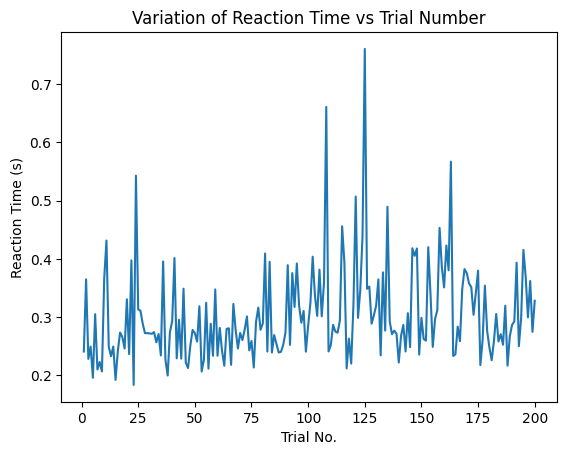

In [5]:
plt.plot(data["TN"], data["Reaction Time"])
plt.title("Variation of Reaction Time vs Trial Number")
plt.xlabel("Trial No.")
plt.ylabel("Reaction Time (s)")
plt.show()

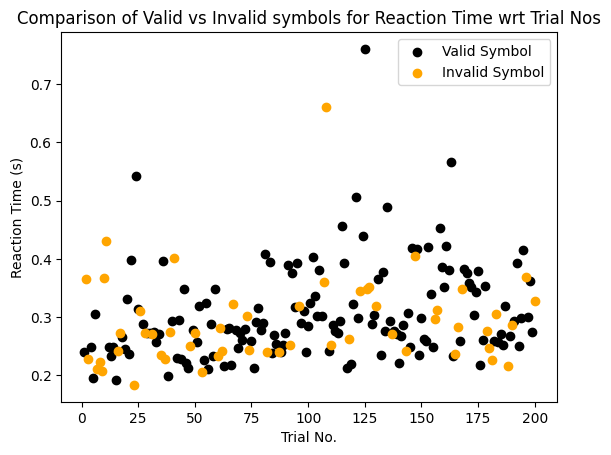

In [39]:
valid_data = data[data["Valid"]=="T"]
invalid_data = data[data["Valid"]=="F"]
plt.scatter(valid_data["TN"], valid_data["Reaction Time"], color="black", label="Valid Symbol")
plt.scatter(invalid_data["TN"], invalid_data["Reaction Time"], color="orange", label="Invalid Symbol")
plt.xlabel("Trial No.")
plt.ylabel("Reaction Time (s)")
plt.legend()
plt.title("Comparison of Valid vs Invalid symbols for Reaction Time wrt Trial Nos")
plt.show()

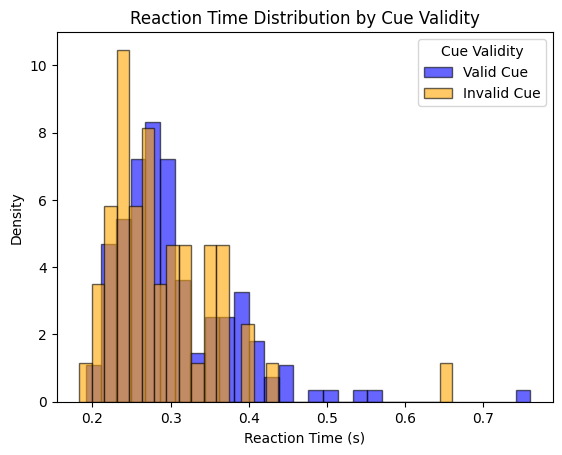

In [48]:
valid_rt = valid_data["Reaction Time"]
invalid_rt = invalid_data["Reaction Time"]

plt.hist(valid_rt, bins=30, density=True, alpha=0.6, label='Valid Cue', color='blue', edgecolor='black')
plt.hist(invalid_rt, bins=30, density=True, alpha=0.6, label='Invalid Cue', color='orange', edgecolor='black')

plt.xlabel("Reaction Time (s)")
plt.ylabel("Density")
plt.title("Reaction Time Distribution by Cue Validity")
plt.legend(title="Cue Validity")

plt.show()

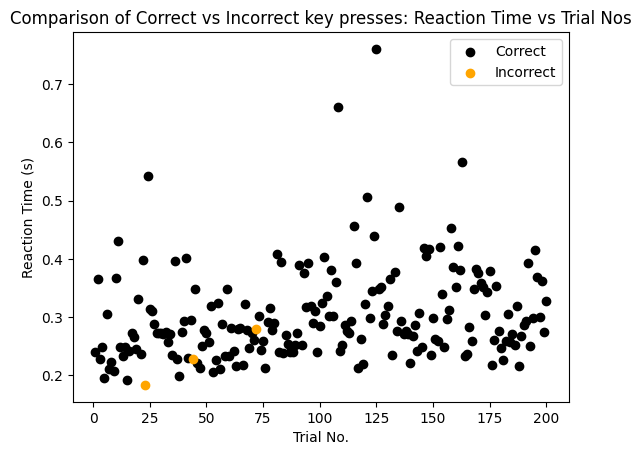

In [42]:
correct_data = data[data["Correct"]=="T"]
incorrect_data = data[data["Correct"]=="F"]
plt.scatter(correct_data["TN"], correct_data["Reaction Time"], color="black", label="Correct")
plt.scatter(incorrect_data["TN"], incorrect_data["Reaction Time"], color="orange", label="Incorrect")
plt.xlabel("Trial No.")
plt.ylabel("Reaction Time (s)")
plt.legend()
plt.title("Comparison of Correct vs Incorrect key presses: Reaction Time vs Trial Nos")
plt.show()

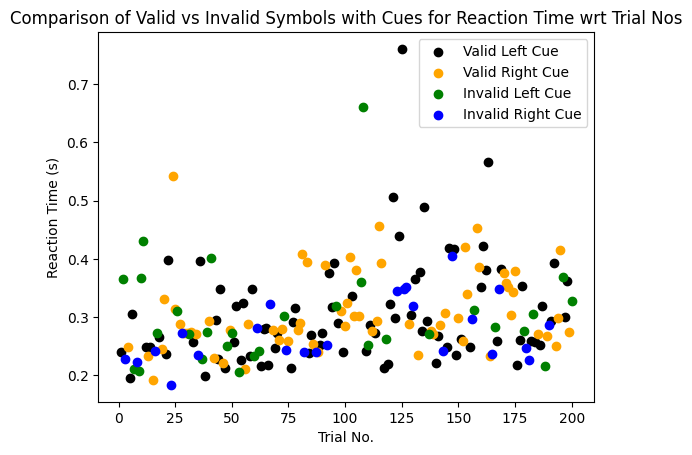

In [45]:
plot1 = data[(data["Valid"] == "T") & (data["Cue"] == "L")]
plot2 = data[(data["Valid"] == "T") & (data["Cue"] == "R")]
plot3 = data[(data["Valid"] == "F") & (data["Cue"] == "L")]
plot4 = data[(data["Valid"] == "F") & (data["Cue"] == "R")]

plt.scatter(plot1["TN"], plot1["Reaction Time"], color="black", label="Valid Left Cue")
plt.scatter(plot2["TN"], plot2["Reaction Time"], color="orange", label="Valid Right Cue")
plt.scatter(plot3["TN"], plot3["Reaction Time"], color="green", label="Invalid Left Cue")
plt.scatter(plot4["TN"], plot4["Reaction Time"], color="blue", label="Invalid Right Cue")

# Labels, Title, and Legend
plt.xlabel("Trial No.")
plt.ylabel("Reaction Time (s)")
plt.legend()
plt.title("Comparison of Valid vs Invalid Symbols with Cues for Reaction Time wrt Trial Nos")
plt.show()


In [25]:
def dataset_formation(data):
    
    # Filter correct responses
    correct_cue_data = data[data['Correct'] == 'T']

    # Summarize statistics for valid and invalid cues
    summary = correct_cue_data.groupby('Valid').agg(
        mean_rt=('Reaction Time', 'mean'),
        rt_variance=('Reaction Time', 'var'),
        accuracy=('Correct', 'count')  # Proportion correct needs all trials
    ).reset_index()

    # type(summary)
    print(summary.head())
    
    total_trials = data.groupby('Valid')['TN'].count().reset_index() #.rename(columns={'TN': 'total_trials'})
    summary = summary.merge(total_trials, on='Valid')
    summary['accuracy'] = summary['accuracy'] / summary['TN']
    
    print("Accuracies present in the Data Summary: \n",summary["accuracy"])
    
    invalid_accuracy = summary[(summary['accuracy'] <= 0) | (summary['accuracy'] >= 1)]
    print("Rows with invalid accuracy values:")
    print(invalid_accuracy)
    
    return summary

## Model Equations from textbook

In [17]:
def ez_diffusion_model_v2(accuracy, rt_mean, rt_variance, scaling_param=0.1):
    """
    Parameters:
    - accuracy: Probability of correct responses (P_c).
    - rt_mean: Mean reaction time for correct responses.
    - rt_variance: Variance of reaction times for correct responses.
    - scaling_param: Scaling parameter (s), default is 0.1.

    Returns:
    - drift_rate (v)
    - boundary_separation (a)
    - non_decision_time (Ter)
    """
    
    if accuracy <= 0 or accuracy >= 1:
        raise ValueError("Accuracy must be between 0 and 1 (exclusive).")
    if rt_variance <= 0:
        raise ValueError("RT variance must be positive.")

    logit_pc = np.log(accuracy / (1 - accuracy))

    # Drift rate (v)
    drift_rate = (
        np.sign(accuracy - 0.5)
        * scaling_param
        * np.sqrt(
            (logit_pc * (accuracy**2 * logit_pc - accuracy * logit_pc + accuracy - 0.5)) / rt_variance
        )
    )

    # Boundary separation (a)
    boundary_separation = (scaling_param**2 * logit_pc) / drift_rate

    # Non-decision time (Ter)
    non_decision_time = rt_mean - (boundary_separation / (2 * drift_rate))

    return drift_rate, boundary_separation, non_decision_time


In [19]:
def pass_data(summary):
    # Apply EZ-diffusion model for each condition using ez_diffusion_model_v2
    for _, row in summary.iterrows():
        v, a, Ter = ez_diffusion_model_v2(row['accuracy'], row['mean_rt'], row['rt_variance'])  # Updated function call
        print(f"Condition: {'Valid' if row['Valid'] == 'T' else 'Invalid'}")
        print(f"  Drift Rate (v): {v:.4f}")
        print(f"  Boundary Separation (a): {a:.4f}")
        print(f"  Non-Decision Time (Ter): {Ter:.4f} seconds\n")
    
    return v, a, Ter

In [20]:
# data2=pd.read_csv("posnerData_S2.txt", sep="\t")
data3=pd.read_csv("posnerData_S3.txt", sep="\t")
data4=pd.read_csv("posnerData_S4.txt", sep="\t")

In [28]:
summary2 = dataset_formation(data)
v2, a2, Ter2 = pass_data(summary2)

  Valid   mean_rt  rt_variance  accuracy
0     F  0.292183     0.005770        53
1     T  0.306985     0.006569       144
Accuracies present in the Data Summary: 
 0    0.981481
1    0.986301
Name: accuracy, dtype: float64
Rows with invalid accuracy values:
Empty DataFrame
Columns: [Valid, mean_rt, rt_variance, accuracy, TN]
Index: []
Condition: Invalid
  Drift Rate (v): 1.6783
  Boundary Separation (a): 0.0237
  Non-Decision Time (Ter): 0.2851 seconds

Condition: Valid
  Drift Rate (v): 1.6702
  Boundary Separation (a): 0.0256
  Non-Decision Time (Ter): 0.2993 seconds



In [26]:
summary3 = dataset_formation(data3)
v3, a3, Ter3 = pass_data(summary3)

  Valid   mean_rt  rt_variance  accuracy
0     F  0.295777     0.006429        52
1     T  0.294192     0.003716       144
Accuracies present in the Data Summary: 
 0    0.981132
1    0.979592
Name: accuracy, dtype: float64
Rows with invalid accuracy values:
Empty DataFrame
Columns: [Valid, mean_rt, rt_variance, accuracy, TN]
Index: []
Condition: Invalid
  Drift Rate (v): 1.5835
  Boundary Separation (a): 0.0250
  Non-Decision Time (Ter): 0.2879 seconds

Condition: Valid
  Drift Rate (v): 2.0470
  Boundary Separation (a): 0.0189
  Non-Decision Time (Ter): 0.2896 seconds



In [27]:
summary4 = dataset_formation(data4)
v4, a4, Ter4 = pass_data(summary4)

  Valid   mean_rt  rt_variance  accuracy
0     F  0.375446     0.018793        45
1     T  0.353903     0.036194       150
Accuracies present in the Data Summary: 
 0    0.937500
1    0.986842
Name: accuracy, dtype: float64
Rows with invalid accuracy values:
Empty DataFrame
Columns: [Valid, mean_rt, rt_variance, accuracy, TN]
Index: []
Condition: Invalid
  Drift Rate (v): 0.6339
  Boundary Separation (a): 0.0427
  Non-Decision Time (Ter): 0.3417 seconds

Condition: Valid
  Drift Rate (v): 0.7168
  Boundary Separation (a): 0.0602
  Non-Decision Time (Ter): 0.3119 seconds



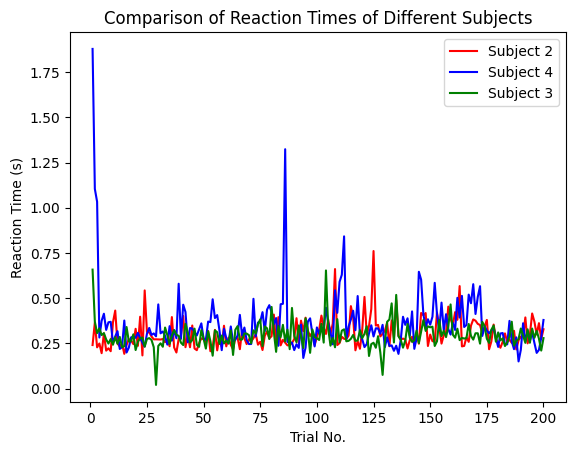

In [50]:
plt.plot(data["TN"], data["Reaction Time"], color="red", label="Subject 2")
plt.plot(data4["TN"], data4["Reaction Time"], color="blue", label="Subject 4")
plt.plot(data3["TN"], data3["Reaction Time"], color="green", label="Subject 3")
plt.title("Comparison of Reaction Times of Different Subjects")
plt.legend()
plt.xlabel("Trial No.")
plt.ylabel("Reaction Time (s)")
plt.show()

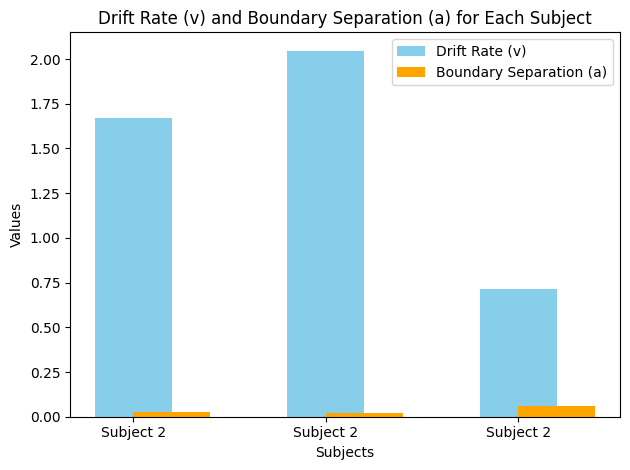

In [56]:
subjects = ["Subject 2", "Subject 2", "Subject 2"]
drift_vels = np.array([v2,v3,v4])
bound_sep = np.array([a2,a3,a4])
num_sub = range(len(subjects))

plt.bar(num_sub, drift_vels, width=0.4, label='Drift Rate (v)', color='skyblue', align='center')
plt.bar(num_sub, bound_sep, width=0.4, label='Boundary Separation (a)', color='orange', align='edge')

plt.xticks(num_sub, subjects)  
plt.xlabel('Subjects')
plt.ylabel('Values')
plt.title('Drift Rate (v) and Boundary Separation (a) for Each Subject')
plt.legend()
plt.tight_layout()
plt.show()
